In [1]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np 
import matplotlib.pyplot as plt

from flow.nvp import RealNVP

In [16]:
# Data
data_dim = 2 
noise = 0.05
# Model
H = 512 # Hidden size
L = 3 # Layers
# Optimisation
lr = 3e-4
n_steps = 5000
batch_size = 100

In [18]:
net_s = lambda: nn.Sequential(
    nn.Linear(data_dim, H), 
    nn.Tanh(),
    nn.Linear(H, H), 
    nn.Tanh(),
    nn.Linear(H, data_dim), 
    nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(data_dim, H), 
    nn.Tanh(), 
    nn.Linear(H, H), 
    nn.Tanh(), 
    nn.Linear(H, data_dim)
)

masks = torch.from_numpy(np.array([[0., 1.], [1., 0.]] * 3)).float()

m = torch.arange(data_dim) % 2

masks = torch.cat(
    [
        torch.flip(m.float(), dims=(0,)) if i % 2 == 0 
        else m
        for i in range(3)
    ]
)
print(masks)

prior = td.MultivariateNormal(torch.zeros(data_dim), torch.eye(data_dim))

flow = RealNVP(net_s, net_t, masks, prior)

tensor([1., 0., 0., 1., 1., 0.])


In [5]:
field_type = "LN"
data_dir = "data/"
X = np.load(os.path.join(data_dir, field_type + "_fields.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

print(X.shape, Y.shape)

(20000, 64, 64) (20000, 2)


In [6]:
def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return torch.as_tensor(X[ix]).float(), torch.as_tensor(Y[ix]).float()

optimizer = torch.optim.Adam(
    [p for p in flow.parameters() if p.requires_grad], lr=lr
)
losses = []
for t in range(n_steps):    

    x, y = get_data(batch_size)

    loss = -flow.log_prob(x).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    losses.append(loss.item())
    
    if t % 500 == 0:
        print(f"{t=:05d} {loss=:.3E}")

RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 2

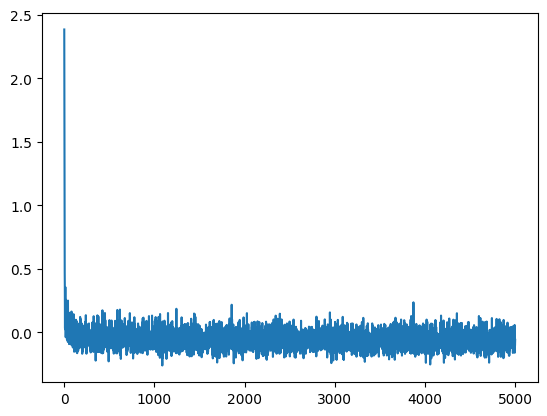

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

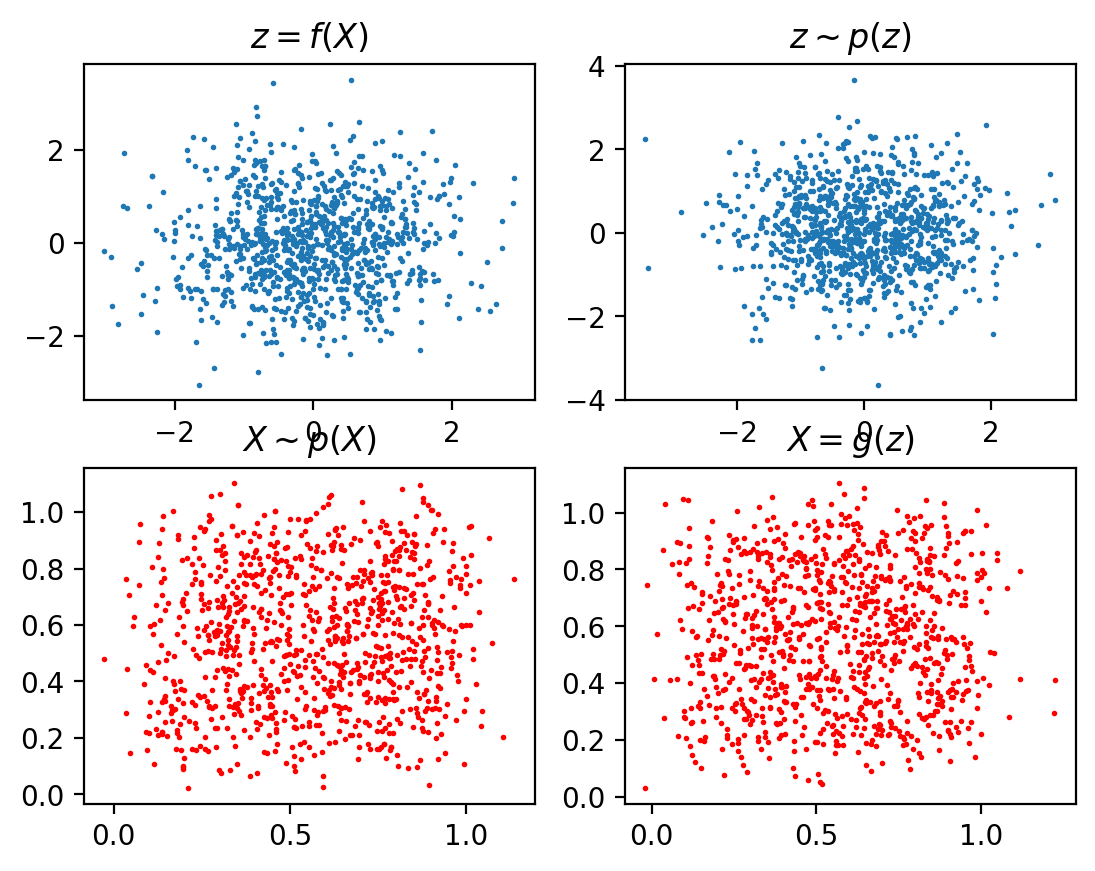

In [ ]:
plt.figure(dpi=200)

x, y = get_data(n=1000)
z = flow.forward(x)[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z = f(X)$')

z = prior.sample((1000,))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x, y = get_data(n=1000)
plt.scatter(x[:, 0], x[:, 1], c='r', s=1.)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r', s=1.)
plt.title(r'$X = g(z)$')

plt.show()